## 3.1.1 Product categories

Let's examine Olist's product categories by volume of sales. We'll only analyze product category and product weight:

In [1]:
import sqlite3
import pandas as pd
db_path = 'C:/Users/gregoG/Documents/python/Olist_analysis/olist.sqlite'
db_connection = sqlite3.connect(db_path)

There are 71 unique product categories. I'll choose the top 18 and group the rest into 'Other categories'. To start, let's get the total sales for each category. We'll also use the product_category_name_translation table which contains the category names in English:

In [2]:
ranked_categories = """
SELECT
    product_category_name_english AS category,
    SUM(price) AS sales,
    RANK() OVER (ORDER BY SUM(price) DESC) AS rank
FROM order_items
    JOIN orders USING (order_id)
    JOIN products USING (product_id)
    JOIN product_category_name_translation USING (product_category_name)
WHERE order_status = 'delivered'
GROUP BY product_category_name_english
"""

pd.read_sql_query(ranked_categories, db_connection)

,category,sales,rank
0,health_beauty,1233131.72,1
1,watches_gifts,1166176.98,2
2,bed_bath_table,1023434.76,3
3,sports_leisure,954852.55,4
4,computers_accessories,888724.61,5
...,...,...,...
66,flowers,1110.04,67
67,home_comfort_2,760.27,68
68,cds_dvds_musicals,730.00,69
69,fashion_childrens_clothes,519.95,70


Now we'll use the previous query as a CTE, and we'll use the rank column to take the first 18th categories by sales and aggregate the rest. UNION ALL merges the two subqueries, making sure that 'Other categories' will appear at the end of the result set:

In [3]:
category_sales_summary = f"""
WITH RankedCategories AS (
    {ranked_categories}
)
-- Top 18 categories by sales
SELECT
    category,
    sales
FROM RankedCategories
WHERE rank <= 18
-- Other categories, aggregated
UNION ALL
SELECT
    'Other categories' AS category,
    SUM(sales) AS sales
FROM RankedCategories
WHERE rank > 18
"""

df = pd.read_sql_query(category_sales_summary, db_connection)
df

,category,sales
0,health_beauty,1233131.72
1,watches_gifts,1166176.98
2,bed_bath_table,1023434.76
3,sports_leisure,954852.55
4,computers_accessories,888724.61
5,furniture_decor,711927.69
6,housewares,615628.69
7,cool_stuff,610204.10
8,auto,578966.65
9,toys,471286.48


### 3.1.2 Visualization

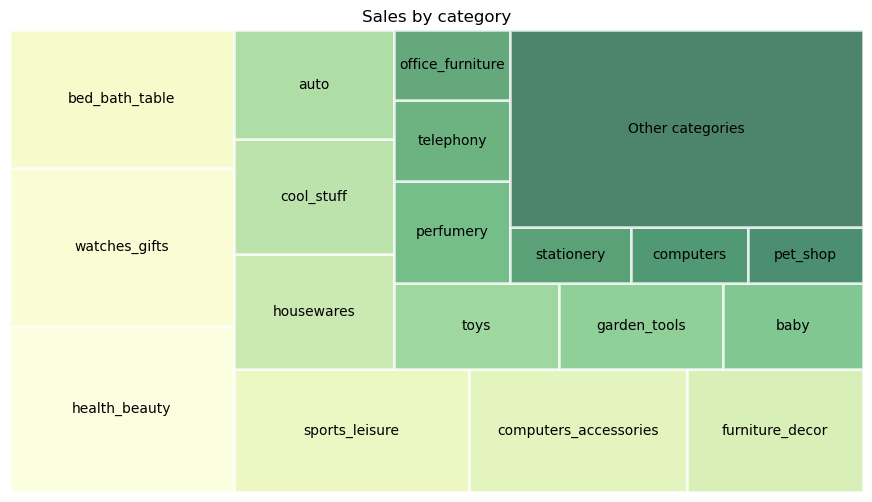

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import squarify 

plt.figure(figsize=(11, 6))
plt.title('Sales by category')
color = sns.color_palette("YlGn", len(df))
squarify.plot(sizes=df['sales'], label=df['category'],
              alpha=0.7, color=color, edgecolor="white", linewidth=2)
plt.axis('off')
plt.show()

## 3.2.1 Product weight

We can gain more insight into the types of products these categories contain by visualizing the distribution of product weight by category using a set of box plots. To build the query for the weight of each product, we'll reuse the list of categories from the previous dataframe:

In [5]:
top_18_categories = tuple(category for category in df['category'] if category != 'Other categories')

It would be helpful to sort the boxes using the median of each category. We could easily calculate the medians in Python, although in the spirit of this challenge, let's do it using SQL. Unfortunately, SQLite doesn't have a function to calculate the median for each category, so we'll sort the products in each category using row numbers, and we'll also add the count of products for each category. We'll save the resulting dataframe to use it as the data source for the plot:

In [6]:
ordered_categories = f"""
SELECT
    product_weight_g AS weight,
    product_category_name_english AS category,
    ROW_NUMBER() OVER(PARTITION BY product_category_name_english ORDER BY product_weight_g)
        AS category_row_n,
    COUNT(*) OVER(PARTITION BY product_category_name_english) AS category_count
FROM
    products
    JOIN order_items USING (product_id)
    JOIN product_category_name_translation USING (product_category_name)
WHERE
    product_category_name_english IN {top_18_categories}
"""

df = pd.read_sql_query(ordered_categories, db_connection)
df

,weight,category,category_row_n,category_count
0,50.0,auto,1,4235
1,50.0,auto,2,4235
2,50.0,auto,3,4235
3,50.0,auto,4,4235
4,50.0,auto,5,4235
...,...,...,...,...
92419,15267.0,watches_gifts,5987,5991
92420,15267.0,watches_gifts,5988,5991
92421,15267.0,watches_gifts,5989,5991
92422,17175.0,watches_gifts,5990,5991


We can build on the previous query string ordered_categories to calculate the median for each category and return them sorted by medians:

In [7]:
categories_by_median = f"""
WITH OrderedCategories AS (
    {ordered_categories}
)
SELECT category
FROM OrderedCategories
WHERE
    -- Odd number of products: Select the middle row
    (category_count % 2 = 1 AND category_row_n = (category_count + 1) / 2) OR
    -- Even number of products: Select the two middle rows to be averaged
    (category_count % 2 = 0 AND category_row_n IN ((category_count / 2), (category_count / 2 + 1)))
GROUP BY category
ORDER BY AVG(weight)
"""

categories_by_median_df = pd.read_sql_query(categories_by_median, db_connection)
categories_by_median_df

,category
0,telephony
1,computers_accessories
2,watches_gifts
3,health_beauty
4,perfumery
5,baby
6,sports_leisure
7,toys
8,pet_shop
9,auto


### 3.2.2 Visualization

Now we can build the box plots, using the result of the previous query to order them:

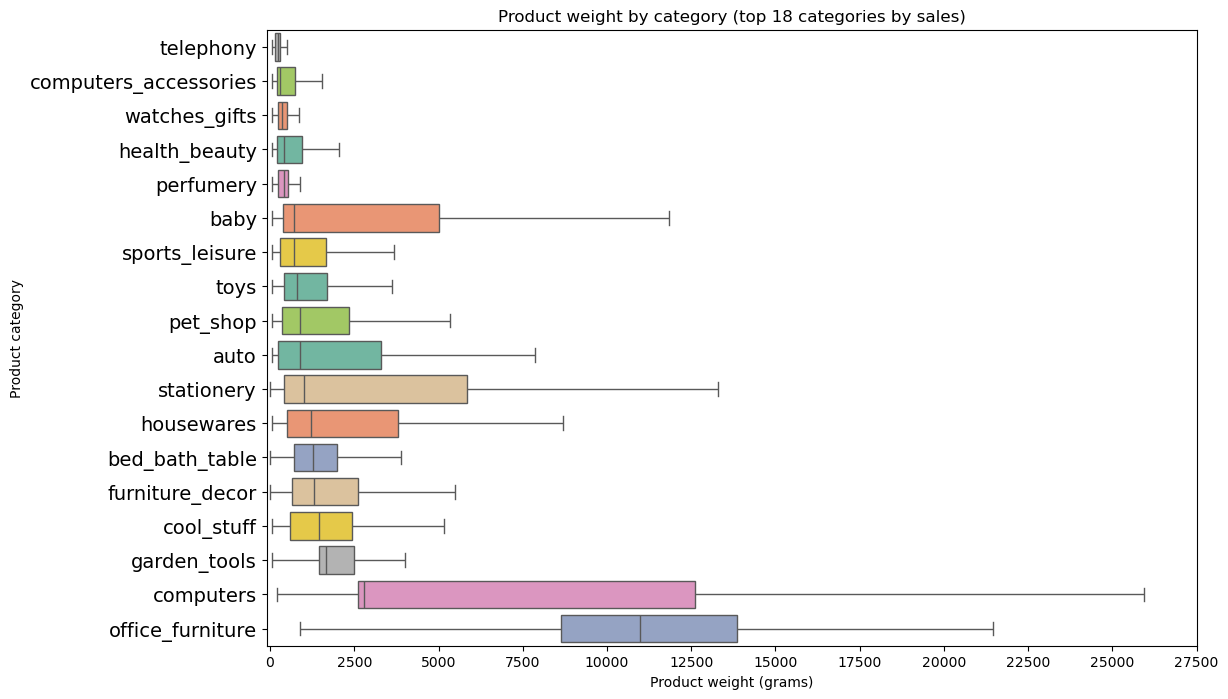

In [8]:
plt.figure(figsize=(12, 8))
order = categories_by_median_df['category'].tolist()
sns.boxplot(x='weight', y='category', data=df, order=order, showfliers=False,palette="Set2", hue="category")
plt.xlabel('Product weight (grams)')
plt.ylabel('Product category')
plt.title('Product weight by category (top 18 categories by sales)')
plt.xlim(-100, 26100)
plt.xticks(ticks=range(0, 30000, 2500))
plt.yticks(fontsize=14)
plt.show()

As we can see at the top of the plot, there are five categories whose items are mostly under 2 Kg: 'telephony', 'computers_accessories', 'watches_gifts', 'health_beauty'. At the bottom, we can see two categories, 'computers' and 'office_furniture', that include much heavier products.